<a href="https://colab.research.google.com/github/nickchak21/QuarkGluonClassifiers/blob/master/Executable_Colab_Notebooks/EMD/EMD_tagger_herwig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing the energyflow and h5py packages in the Colab environment

In [1]:
!pip install energyflow
!pip install h5py

     |████████████████████████████████| 696kB 4.8MB/s 
     |████████████████████████████████| 2.9MB 46.1MB/s 
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0


Checking the version of Python (should be Python 3.6)

In [2]:
!python --version

Python 3.6.9


Installing POT (Python Optimal Transport) package

In [3]:
!pip install POT

     |████████████████████████████████| 307kB 4.6MB/s 


The following code runs a quark gluon classifier using a EMD (Energy Mover's Distance) tagger. The input jets are Pythia-generated. The AUC tops out at around 0.81. This model loads 200 candidate jets and 4000 known jets. The candidate jets are evaluated by calculating each EMD to the known jets, then selecting the n closest jets. Then, if quark-originating jets are more present among the n closest jets, the candidate is classified as a quark. Vice versa for gluons.

In [0]:
import numpy as np
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

from energyflow.emd import emd, emds
from energyflow.datasets import qg_jets
from energyflow.utils import sum_ptyphipids
import ot

from sklearn.metrics import roc_auc_score, roc_curve
from ot.lp import emd_c, check_result
from scipy.spatial.distance import _distance_wrap

In [0]:
# data controls.
# we will use the n nearest neighbors in the "electorate" to vote on what kind of jet each candidate is.
candidates, electorate = 200, 2000

In [6]:
# load quark and gluon jets from Pythia. We want candidates + electorate of *each.*
# Quarks are labeled "1" in this dataset, gluons are "0"

# Shapes of jet,label are: (num_data,max_num_particles,4) and (num_data).
# coordinates are:  (pt,y,phi,pid)
# pad=False makes array of objects, not numbers.
# Load extrajets to be sure we get enough of each type.
extrajets = candidates
jets,labels = qg_jets.load(2*(candidates + electorate + extrajets), generator='herwig', pad=False)
maxevts = candidates+electorate
nprint = int(maxevts*maxevts/10)

# the jet radius for these jets
jetR = 0.4

In [7]:
#normalizing jets and center pts
Gs = []
Qs = []

for arr,events in [(Gs, jets[labels==0]), (Qs, jets[labels==1])]:
    for i,x in enumerate(events):
        if i >= maxevts:  break
        # ignore padded particles (not used) and remove particle id information(:3)
        x = x[x[:,0] > 0,:3]
        # center jet according to pt-centroid
        yphi_avg = np.average(x[:,1:3], weights=x[:,0], axis=0)
        x[:,1:3] -= yphi_avg
        # mask out any particles farther than R=0.4 away from center (rare)
        x = x[np.linalg.norm(x[:,1:3], axis=1) <= jetR]
        # add to list
        arr.append(x)
        pass #evts
    pass #gluonquark

#amount of items in quark and gluon sets
len(Gs), len(Qs)

(2200, 2200)

In [8]:
#constituent/electorate list. These particles will "vote" on whether candidate is quark or gluon
constituentList = Gs[candidates:]+Qs[candidates:]
len(constituentList)

4000

In [9]:
#array of distances of gluon candidate from all constituents. shape is (candidates,constituents)
costM_g  = emds(Gs[0:candidates], constituentList, R=jetR, norm=True, verbose=1, n_jobs=4, print_every=nprint)
#ditto for quarks.
costM_q  = emds(Qs[0:candidates], constituentList, R=jetR, norm=True, verbose=1, n_jobs=4, print_every=nprint)

Processed 4200 events for asymmetric EMD computation in 0.099s
Using 4 worker processes:
  Computed 484000 EMDs, 60.50% done in 98.09s
  Computed 800000 EMDs, 100.00% done in 163.16s
Processed 4200 events for asymmetric EMD computation in 0.039s
Using 4 worker processes:
  Computed 484000 EMDs, 60.50% done in 69.65s
  Computed 800000 EMDs, 100.00% done in 111.82s


In [0]:
#returns the sorted list indices of costM_g and costM_q
indicesG=np.argsort(costM_g)
indicesQ=np.argsort(costM_q)

In [0]:
#generates predictions for particles using 10 closest jets (according to EMD)
h_Gten_array = []
h_Qten_array = []
h_Gtwt_array = []
h_Qtwt_array = []

nVoters = 10
for i in range(candidates): h_Gten_array.append(sum(indicesG[i,:nVoters] < electorate)/nVoters)
for i in range(candidates): h_Qten_array.append(sum(indicesQ[i,:nVoters] < electorate)/nVoters)
nVoters = 20
for i in range(candidates): h_Gtwt_array.append(sum(indicesG[i,:nVoters] < electorate)/nVoters)  
for i in range(candidates): h_Qtwt_array.append(sum(indicesQ[i,:nVoters] < electorate)/nVoters)

In [0]:
#calculates AUC score for classification using 10 closest jets

h_Gten_nparray = np.asarray(h_Gten_array)
h_Qten_nparray = np.asarray(h_Qten_array)
h_Gtwt_nparray = np.asarray(h_Gtwt_array)
h_Qtwt_nparray = np.asarray(h_Qtwt_array)

true_y_g = np.ones(200)
true_y_q = np.zeros(200)

true_values = np.concatenate([true_y_g, true_y_q])

ten_predicted = np.concatenate([h_Gten_nparray, h_Qten_nparray])
emd_auc_10 = roc_auc_score(y_true=true_values, y_score=ten_predicted)

In [13]:
#print AUC score for 10 closest jets
print("EMD AUC 10 voters: ", emd_auc_10)

EMD AUC 10 voters:  0.7783625000000001


In [14]:
#print AUC score for 20 closest jets
twt_predicted = np.concatenate([h_Gtwt_nparray, h_Qtwt_nparray])
emd_auc_20 = roc_auc_score(y_true=true_values, y_score=twt_predicted)
print("EMD AUC 20 voters: ", emd_auc_20)

EMD AUC 20 voters:  0.7871875


Testing out different numbers of voters to find an optimum

In [0]:
h_G_array = []
h_Q_array = []
emd_list = []

In [0]:
#generates list of AUC for nVoters ranging from 10 - 199
for nVoters in range(10,200):
    for i in range(candidates): h_G_array.append(sum(indicesG[i,:nVoters] < electorate)/nVoters)
    for i in range(candidates): h_Q_array.append(sum(indicesQ[i,:nVoters] < electorate)/nVoters)
    h_G_nparray = np.asarray(h_G_array)
    h_Q_nparray = np.asarray(h_Q_array)
    predicted = np.concatenate([h_G_nparray, h_Q_nparray])
    emd_auc = roc_auc_score(y_true=true_values, y_score=predicted)
    emd_list.append(emd_auc)
    h_G_array = []
    h_Q_array = []

emd_auc_array = np.asarray(emd_list)

In [17]:
#print the AUC array
print(emd_auc_array)

[0.7783625 0.780725  0.784475  0.782925  0.781575  0.7837625 0.7847125
 0.779675  0.7827625 0.7851625 0.7871875 0.782075  0.7847625 0.784875
 0.7866625 0.7891625 0.7892    0.793875  0.794925  0.79785   0.795975
 0.79475   0.7921125 0.7919875 0.7914    0.791325  0.792375  0.7959625
 0.7990125 0.7993625 0.799375  0.8009    0.79925   0.798975  0.797025
 0.7984125 0.798825  0.80015   0.7990125 0.798275  0.79705   0.795925
 0.7962375 0.79805   0.79855   0.7974125 0.7981375 0.796825  0.795925
 0.7973    0.7985375 0.79985   0.7984875 0.798175  0.798175  0.798525
 0.7972125 0.7971125 0.7966375 0.7976375 0.7972875 0.79795   0.7966625
 0.7955375 0.7958375 0.7953125 0.7957125 0.7952375 0.794275  0.7943125
 0.795525  0.796925  0.797075  0.7960375 0.7967625 0.7982125 0.7982625
 0.7983375 0.7980125 0.7993875 0.7999375 0.7996125 0.800025  0.8016
 0.8027375 0.8040875 0.8035    0.804625  0.80355   0.8041625 0.8050625
 0.8051875 0.80595   0.8058    0.80635   0.8062    0.80655   0.807375
 0.8084375 0.809

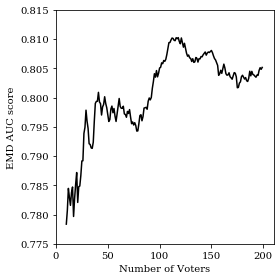

In [21]:
#graph the EMD AUC score with respect to the number of voters used
number_voters = np.arange(10,200)
if plt:
    # some nicer plot settings
    plt.rcParams['figure.figsize'] = (4,4)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['figure.autolayout'] = True

    # plot the ROC curves
    plt.plot(number_voters, emd_auc_array, '-', color='black')

     # axes labels
    plt.xlabel('Number of Voters')
    plt.ylabel('EMD AUC score')

    # axes limits
    plt.xlim(0, 210)
    plt.ylim(0.775, 0.815)

    plt.show()

In [19]:
#print maximum AUC
max_auc = np.amax(emd_auc_array)
print(max_auc)

0.8102625


In [20]:
#print the optimal number of voters that maximizes the AUC
opt_voters = np.argmax(emd_auc_array) + 10 #since we started with 10 voters
print(opt_voters)

118
